# 1. Sleep well (35 points)

In [74]:
import pandas as pd

# Load the data
X_train = pd.read_csv('data\Sleep-EDF-15_U-Time/X_train.csv', header=None)
y_train = pd.read_csv('data\Sleep-EDF-15_U-Time/y_train.csv', header=None)
X_test = pd.read_csv('data\Sleep-EDF-15_U-Time/X_test.csv', header=None)
y_test = pd.read_csv('data\Sleep-EDF-15_U-Time/y_test.csv', header=None)

## 1.1 Data understanding and preprocessing

In [75]:
# Calculate class frequencies for training dat, normalized to [0,1]
class_frequencies = y_train.value_counts(normalize=True)

# Print each class frequency for training data
print("Class frequencies for training data:")
for label, freq in class_frequencies.items():
    print(f"Class {label}: {freq*100:.2f}%")

Class frequencies for training data:
Class (0.0,): 52.09%
Class (2.0,): 25.27%
Class (1.0,): 9.55%
Class (4.0,): 8.39%
Class (3.0,): 4.69%


## 1.2 Classification

In [76]:
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classifier(y_true_train, y_pred_train, y_true_test, y_pred_test, classifier_name):
    print(f"Evaluation Metrics for {classifier_name}:")

    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    print(f"Training:\n {confusion_matrix(y_true_train, y_pred_train)}")
    print(f"Test:\n {confusion_matrix(y_true_test, y_pred_test)}")

    # Zero-One Loss
    print(f"\nZero-One Loss:")
    print(f"Training: {zero_one_loss(y_true_train, y_pred_train):.3f}")
    print(f"Test: {zero_one_loss(y_true_test, y_pred_test):.3f}")

    # Accuracy
    print(f"\nAccuracy")
    print(f"Training: {accuracy_score(y_true_train, y_pred_train):.3f}")
    print(f"Test: {accuracy_score(y_true_test, y_pred_test):.3f}")

    # Precision
    print(f"\nPrecision:")
    print(f"Training: {precision_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {precision_score(y_true_test, y_pred_test, average='macro'):.3f}")

    # Recall
    print(f"\nRecall:")
    print(f"Training: {recall_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {recall_score(y_true_test, y_pred_test, average='macro'):.3f}")

    # F1 Score
    print(f"\nF1 Score:")
    print(f"Training: {f1_score(y_true_train, y_pred_train, average='macro'):.3f}")
    print(f"Test: {f1_score(y_true_test, y_pred_test, average='macro'):.3f}")

### Multi-nominal Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression

# Build and train the model
logistic_model = LogisticRegression(max_iter=10000)  # Default is L2 regularization
logistic_model.fit(X_train, y_train.values.ravel())

# Predict and evaluate
train_pred = logistic_model.predict(X_train)
test_pred = logistic_model.predict(X_test)

evaluate_classifier(y_train, train_pred, y_test, test_pred, "Logistic Regression")

Evaluation Metrics for Logistic Regression:

Confusion Matrix:
Training:
 [[16993   404    37    12   120]
 [  532  1322  1012     5   350]
 [   62   446  7226   314   475]
 [   10     7   662   896     8]
 [   64   180   342     0  2245]]
Test:
 [[7437  124    9    3    6]
 [  78  412  182    1  102]
 [  15  188 3376   83  179]
 [   0    0  135  260    0]
 [  53  161   59    0 1038]]

Zero-One Loss:
Training: 0.150
Test: 0.099

Accuracy
Training: 0.850
Test: 0.901

Precision:
Training: 0.747
Test: 0.775

Recall:
Training: 0.717
Test: 0.768

F1 Score:
Training: 0.727
Test: 0.771


### Random Forests

In [78]:
from sklearn.ensemble import RandomForestClassifier

for n_trees in [50, 100, 200]:
    # Build and train the model
    rf_model = RandomForestClassifier(n_estimators=n_trees)
    rf_model.fit(X_train, y_train.values.ravel())
    
    # Predict and evaluate
    train_pred = rf_model.predict(X_train)
    test_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    evaluate_classifier(y_train, train_pred, y_test, test_pred, f"Random Forest (n_estimators={n_trees})")

Evaluation Metrics for Random Forest (n_estimators=50):

Confusion Matrix:
Training:
 [[17566     0     0     0     0]
 [    2  3216     2     0     1]
 [    1     1  8521     0     0]
 [    0     0     2  1581     0]
 [    1     0     2     0  2828]]
Test:
 [[7451  110   11    2    5]
 [ 114  395  169    0   97]
 [  22  252 3334   71  162]
 [   0    0  176  219    0]
 [ 114  153  105    0  939]]

Zero-One Loss:
Training: 0.000
Test: 0.112

Accuracy
Training: 1.000
Test: 0.888

Precision:
Training: 1.000
Test: 0.762

Recall:
Training: 0.999
Test: 0.726

F1 Score:
Training: 0.999
Test: 0.740
Evaluation Metrics for Random Forest (n_estimators=100):

Confusion Matrix:
Training:
 [[17566     0     0     0     0]
 [    0  3221     0     0     0]
 [    0     0  8523     0     0]
 [    0     0     0  1583     0]
 [    0     0     0     0  2831]]
Test:
 [[7442  114   14    2    7]
 [ 108  391  177    1   98]
 [  18  220 3371   69  163]
 [   0    0  185  210    0]
 [ 125  157   91    0  938]]



### k-Nearest-Neighbor Classification

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 31))}  # Considering 1 to 30 neighbors

# Use GridSearchCV to find the best number of neighbors
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train.values.ravel())

# Train the model with the best number of neighbors
best_knn = grid_search.best_estimator_
train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

# Evaluate the model
evaluate_classifier(y_train, train_pred, y_test, test_pred, "K-Nearest Neighbors")

Evaluation Metrics for K-Nearest Neighbors:

Confusion Matrix:
Training:
 [[17069   355    24    10   108]
 [  499  1488   880     7   347]
 [   68   486  7304   239   426]
 [    9    12   696   860     6]
 [   79   176   375     0  2201]]
Test:
 [[7447  113   10    2    7]
 [  95  405  167    1  107]
 [  17  214 3374   69  167]
 [   0    0  162  233    0]
 [  66  147   64    0 1034]]

Zero-One Loss:
Training: 0.142
Test: 0.101

Accuracy
Training: 0.858
Test: 0.899

Precision:
Training: 0.765
Test: 0.776

Recall:
Training: 0.722
Test: 0.752

F1 Score:
Training: 0.738
Test: 0.762


# 3. Differentiable programming (35 points)

## 3.1 Steepest descent

In [80]:
import torch
import matplotlib.pyplot as plt

### Step 1. Function to optimize

In [81]:
def f(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

### Step 2. Initialize the trainable parameters

In [82]:
r = 2.5  # This seems to be a constant from the original notebook

# Initialize x and y with requires_grad=True
x = torch.ones(1, requires_grad=True)
y = torch.ones(1, requires_grad=True)

# Initialize the values without autograd tracking
with torch.no_grad():
    x *= 0.9 * r
    y *= 0.8 * r

### Step 3. Set up the optimizer for steepest descent

In [83]:
eta = 0.001  # Learning rate (this value might need to be adjusted based on the original notebook)
optimizer = torch.optim.SGD([x, y], lr=eta)

### Step 4. Optimization loop

In [84]:
# Lists to store x, y values for plotting
x_vals, y_vals = [], []

# Optimization loop
for _ in range(10000):  # Number of iterations might need adjustment
    optimizer.zero_grad()  # Reset the gradients
    loss = f(x, y)  # Compute the function value
    loss.backward()  # Compute the gradients
    optimizer.step()  # Update x and y using the gradients
    
    # Store x, y values for plotting
    x_vals.append(x.item())
    y_vals.append(y.item())

### Step 5. Plotting the optimization steps

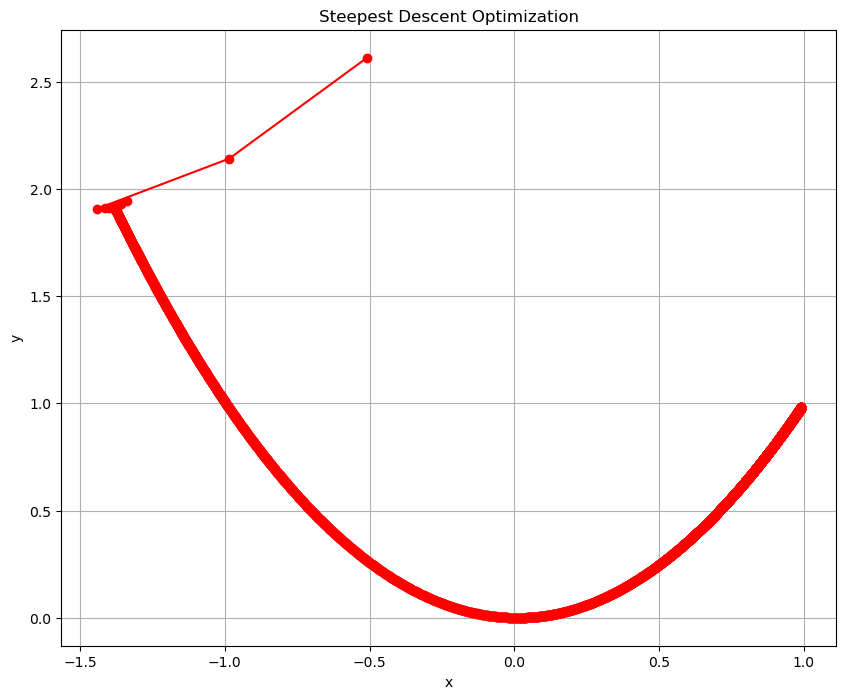

In [85]:
plt.figure(figsize=(10, 8))
plt.plot(x_vals, y_vals, '-o', color='red')
plt.title("Steepest Descent Optimization")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## 3.2 Adam [optional]

### Step 1: Set up the Adam optimizer

In [86]:
eta = 0.5  # Learning rate for Adam
optimizer = torch.optim.Adam([x, y], lr=eta)

### Step 2: Optimization loop
The optimization loop remains largely the same. We'll compute the function value, gradients, and update `x` and `y` using the Adam optimizer.

In [87]:
# Lists to store x, y values for plotting
x_vals, y_vals = [], []

# Optimization loop
for _ in range(10000):  # Number of iterations might need adjustment
    optimizer.zero_grad()  # Reset the gradients
    loss = f(x, y)  # Compute the function value
    loss.backward()  # Compute the gradients
    optimizer.step()  # Update x and y using Adam
    
    # Store x, y values for plotting
    x_vals.append(x.item())
    y_vals.append(y.item())

### Step 3: Plotting the optimization steps

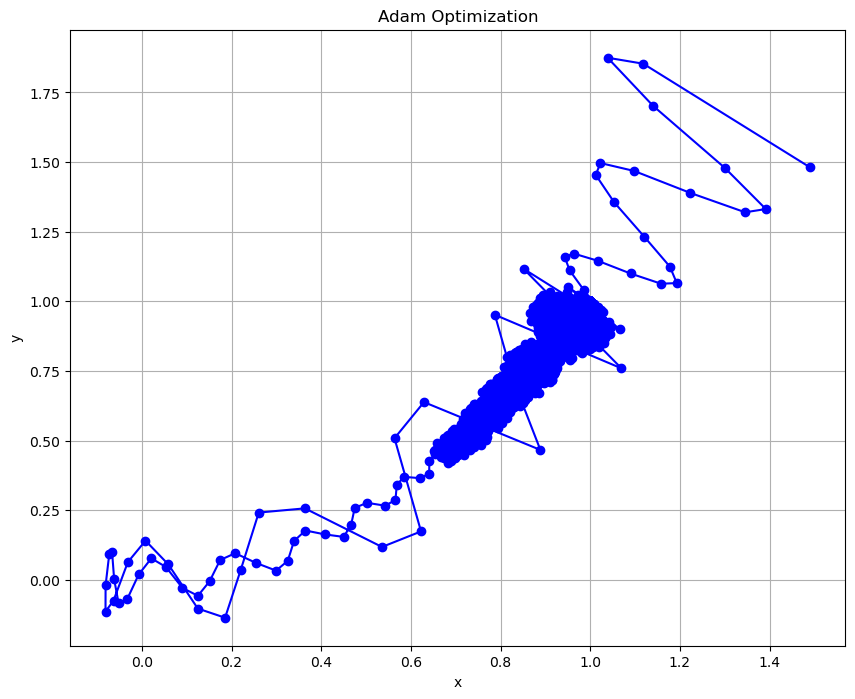

In [88]:
plt.figure(figsize=(10, 8))
plt.plot(x_vals, y_vals, '-o', color='blue')
plt.title("Adam Optimization")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

### Why does the fourth step go in the “wrong” direction?
Adam is an adaptive learning rate optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. One of the key features of Adam is that it uses moving averages of the parameters (momentum) which can sometimes lead to overshooting the optimal point, especially in the early stages of optimization when the moving averages are being established.

In the early iterations, the momentum term can dominate the optimization, causing the update to move in the direction of the momentum rather than the direction of the gradient. This can lead to the optimizer taking steps that appear to be in the "wrong" direction with respect to the gradient. However, as more iterations are performed, the moving averages stabilize, and the optimizer becomes more responsive to the gradient, leading to more consistent convergence towards the minimum.

In summary, the "wrong" direction in the fourth step (or any early step) can be attributed to the momentum term in the Adam optimizer, which can initially dominate the gradient-based updates.